RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes

In [1]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm 

Define RBF, laplacian and RQ kernels, MMD loss and energy distance loss functions:

In [ ]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self): #if we want to scale the bandwiths
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X): #calculates the RBF kernel between each column in X
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
        #dim 0 is the bandwidth dimension : the function returns sum of kernels with different bandwiths defined by self.bandwith_multipliers
        #returns 0 on the diagonal line : dont care for kernel between data point and itself
    
class Laplacian(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = gamma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self): #if we want to scale the bandwiths
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X): #calculates the Laplacian kernel between each column in X
        L1_distances = torch.cdist(X, X, p = 1) 
        return torch.exp(-L1_distances[None, ...] * (self.get_bandwidth() * self.bandwidth_multipliers)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
        #dim 0 is the bandwidth dimension : the function returns sum of kernels with different bandwiths defined by self.bandwith_multipliers
        #returns 0 on the diagonal line : dont care for kernel between data point and itself

class RQ(nn.Module):

    def __init__(self):
        super().__init__()
        self.alpha = torch.tensor([0.25,0.5,1,2,5,10], dtype = torch.float32) #hyper-parameter alpha

    def forward(self, X): #calculates the RQ kernel between each column in X
        L2_distances = torch.cdist(X, X) ** 2 
        return ((1+L2_distances[None, ...] / (2 * self.alpha)[:, None, None])**-self.alpha[:,None,None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
        #dim 0 is the dimension of alpha : the function returns sum of kernels with different alphas defined by self.alpha
        #returns 0 on the diagonal line : dont care for kernel between data point and itself
    
class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y): #calculates the unbiased empirical MMD between X and Y
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY 

class EnergyDistance(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, X, Y): #calculates the unbiased empirical energy distance between X and Y
        data = torch.vstack([X, Y])
        L2_distances = torch.cdist(data, data)

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = L2_distances[:X_size, :X_size].sum()/(X_size**2-X_size)
        XY = L2_distances[:X_size, X_size:].mean()
        YY = L2_distances[X_size:, X_size:].sum()/(Y_size**2-Y_size)
        return -0.5*XX + XY -0.5*YY

Training data:

In [3]:
np.random.seed(0)

N = 20000 
x1 = np.random.normal(0,1,N)
x2 = np.random.normal(0,1,N)
x3 = np.random.normal(0,1,N)
y = np.exp(x1 + x2) + 2*x3**2 + (1+np.sqrt(x1**2)+x2**2)*np.random.normal(0,1,N)
X_input = np.column_stack((x1,x2,x3))

#create tensor data
X_input = torch.tensor(X_input, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

Define and train MMD network with RBF kernel:

In [4]:
np.random.seed(1)
torch.manual_seed(0)

N_input = 100 #dimension of uniformly sampled input
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(X_input.shape[1]+N_input, 200)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(200, 200)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(200, 100)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(100, 100)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(100, 1)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.output(x)
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

#training loop
for epoch in range(n_epochs):
    #shuffle training data:
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size] #predictors
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x]) #model inputs
        y_pred = model(X_model) #generated data
        ybatch = y[i:i+batch_size] #real data
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn(pred, real)
        optimizer.zero_grad() #reset gradient
        loss.backward() #backpropagation
        optimizer.step() #optimizer iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.016739845275878906
Finished epoch 1, latest loss 0.005948305130004883
Finished epoch 2, latest loss 0.02114105224609375
Finished epoch 3, latest loss 0.014004707336425781
Finished epoch 4, latest loss 0.003217458724975586
Finished epoch 5, latest loss 0.0001742839813232422
Finished epoch 6, latest loss -0.0026502609252929688
Finished epoch 7, latest loss 0.0017230510711669922
Finished epoch 8, latest loss -0.000518798828125
Finished epoch 9, latest loss -0.0033245086669921875
Finished epoch 10, latest loss 0.0073087215423583984
Finished epoch 11, latest loss -0.00015664100646972656
Finished epoch 12, latest loss 0.004262685775756836
Finished epoch 13, latest loss 0.0012025833129882812
Finished epoch 14, latest loss 0.0017621517181396484
Finished epoch 15, latest loss -0.0033910274505615234
Finished epoch 16, latest loss 0.003178119659423828
Finished epoch 17, latest loss -0.0033829212188720703
Finished epoch 18, latest loss -0.0019481182098388672
Finishe

Train MMD network with laplacian kernel:

In [5]:
np.random.seed(1)
torch.manual_seed(0)

model_Laplacian = network()

loss_fn_Laplacian = MMDLoss(kernel=Laplacian())
optimizer_Laplacian = optim.RMSprop(model_Laplacian.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

#training loop
for epoch in range(n_epochs):
    #shuffle training data:
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size] #predictors
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x]) #model inputs
        y_pred = model_Laplacian(X_model) #generated data
        ybatch = y[i:i+batch_size] #real data
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn_Laplacian(pred, real)
        optimizer_Laplacian.zero_grad() #reset gradient
        loss.backward() #backpropagation
        optimizer_Laplacian.step() #optimizere iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.00026817619800567627
Finished epoch 1, latest loss 0.0004654005169868469
Finished epoch 2, latest loss -0.0009056255221366882
Finished epoch 3, latest loss -0.00012361258268356323
Finished epoch 4, latest loss -0.0017465129494667053
Finished epoch 5, latest loss 0.000225067138671875
Finished epoch 6, latest loss -0.00037291646003723145
Finished epoch 7, latest loss -0.000645853579044342
Finished epoch 8, latest loss -0.0014716610312461853
Finished epoch 9, latest loss -0.0022888854146003723
Finished epoch 10, latest loss 0.00037366896867752075
Finished epoch 11, latest loss -0.0006969869136810303
Finished epoch 12, latest loss -0.001836635172367096
Finished epoch 13, latest loss -0.002161450684070587
Finished epoch 14, latest loss -0.0021682679653167725
Finished epoch 15, latest loss -0.002289324998855591
Finished epoch 16, latest loss -0.0022865012288093567
Finished epoch 17, latest loss -0.0024526864290237427
Finished epoch 18, latest loss -0.001100167

Train MMD network with RQ kernel:

In [6]:
np.random.seed(1)
torch.manual_seed(0)

model_RQ = network()

loss_fn_RQ = MMDLoss(kernel=RQ())
optimizer_RQ = optim.RMSprop(model_RQ.parameters(), lr=0.001)

n_epochs = 150
batch_size = 400

#training loop
for epoch in range(n_epochs):
    #shuffle training data:
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size] #predictors
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x]) #model inputs
        y_pred = model_RQ(X_model) #generated data
        ybatch = y[i:i+batch_size] #real data
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn_RQ(pred, real)
        optimizer_RQ.zero_grad() #reset gradient
        loss.backward() #backpropagation
        optimizer_RQ.step() #optimizer iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.019985973834991455
Finished epoch 1, latest loss 0.009343504905700684
Finished epoch 2, latest loss 0.011294305324554443
Finished epoch 3, latest loss 0.00988757610321045
Finished epoch 4, latest loss 0.007107257843017578
Finished epoch 5, latest loss 0.0016713142395019531
Finished epoch 6, latest loss 0.004511415958404541
Finished epoch 7, latest loss 0.0012866854667663574
Finished epoch 8, latest loss 0.006785154342651367
Finished epoch 9, latest loss -0.003404557704925537
Finished epoch 10, latest loss -0.00536656379699707
Finished epoch 11, latest loss -0.0025386810302734375
Finished epoch 12, latest loss 0.00028634071350097656
Finished epoch 13, latest loss -0.0006701946258544922
Finished epoch 14, latest loss -0.007308065891265869
Finished epoch 15, latest loss -0.005559384822845459
Finished epoch 16, latest loss -0.0007011294364929199
Finished epoch 17, latest loss 0.0007613897323608398
Finished epoch 18, latest loss 0.0010190606117248535
Finished

Train energy distance network

In [7]:
np.random.seed(1)
torch.manual_seed(0)

model_ED = network()

loss_fn_ED = EnergyDistance()
optimizer_ED = optim.RMSprop(model_ED.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

#training loop
for epoch in range(n_epochs):
    #shuffle training data:
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size] #predictors
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x]) #model inputs
        y_pred = model_ED(X_model) #generated data
        ybatch = y[i:i+batch_size] #real data
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn_ED(pred, real)
        optimizer_ED.zero_grad() #reset gradient
        loss.backward() #backpropagation
        optimizer_ED.step() #optimizer iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.016286134719848633
Finished epoch 1, latest loss 0.026660919189453125
Finished epoch 2, latest loss 0.028940439224243164
Finished epoch 3, latest loss 0.013051986694335938
Finished epoch 4, latest loss 0.06976914405822754
Finished epoch 5, latest loss 0.022992610931396484
Finished epoch 6, latest loss 0.006209373474121094
Finished epoch 7, latest loss 0.0076351165771484375
Finished epoch 8, latest loss -0.0008494853973388672
Finished epoch 9, latest loss -0.004698514938354492
Finished epoch 10, latest loss -0.0031332969665527344
Finished epoch 11, latest loss -0.0021677017211914062
Finished epoch 12, latest loss -0.005247831344604492
Finished epoch 13, latest loss 0.035787105560302734
Finished epoch 14, latest loss -0.001947641372680664
Finished epoch 15, latest loss 0.00392603874206543
Finished epoch 16, latest loss -0.0073816776275634766
Finished epoch 17, latest loss 0.0028533935546875
Finished epoch 18, latest loss 0.023252010345458984
Finished epoch

Test the four models by generating 1000 test data for multiple sets of predictors.
For the generated sample distributions, we compute MSE for mean, sd and quantiles, mean MMDs and energy distance, MAE for mean, sd.

MMD network with RBF kernel:

In [8]:
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []

for i in np.arange(-1,1.2,0.2): #x_1 ([-2,2] takes too long)
    for j in np.arange(-1,1.2,0.2): #x_2
        for k in np.arange(-1,1.2,0.2): #x_3
            x = np.random.uniform(-0.5,0.5,1000*N_input)
            x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
            X_predict = torch.tensor([i,j,k]*1000, dtype=torch.float32).reshape(1000,3)
            X_predict = torch.column_stack([X_predict,x]) #model inputs for predictors i,j,k
            with torch.no_grad(): #do not update gradient
                y_sample = model(X_predict) #model outputs : generated data
            y_compare = np.exp(i + j) + 2*k**2 + (1+np.sqrt(i**2)+j**2)*np.random.normal(0,1,1000) #samples from real distribution
            y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
            #MMDs between real and generated samples:
            MMD_RBF.append(loss_fn(y_sample,y_compare))
            MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
            MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
            #ED between real and generated samples:
            ED.append(loss_fn_ED(y_sample,y_compare))
            #MSEs and MAEs for distribution means, stds and quantiles:
            y_sample = y_sample.reshape(1,-1).numpy()[0]
            MSE_means.append((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2)
            MAE_means.append(np.sqrt((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2))
            MSE_stds.append((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2)
            MAE_stds.append(np.sqrt((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2))
            MSE_quantiles.append((stats.norm.ppf(0.9, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.9))**2) 
            MSE_quantiles10.append((stats.norm.ppf(0.1, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')

-1.0
-0.8
-0.6000000000000001
-0.40000000000000013
-0.20000000000000018
-2.220446049250313e-16
0.19999999999999973
0.3999999999999997
0.5999999999999996
0.7999999999999996
0.9999999999999996
MSE of means: 0.09237383225645708
MSE of standard deviations: 0.15947856112763034
MSE of 0.9 quantiles: 0.5402533050171838
MSE of 0.1 quantiles: 0.2958989356425804
MMD with RBF kernel: 0.030262159183621407
MMD with Laplacian kernel: 0.02826351672410965
MMD with RQ kernel: 0.07480443269014359
Energy distance: 0.026224009692668915
MAE of means: 0.2402106807360334
MAE of standard deviations: 0.3168447636268264


MMD network with laplacian kernel:

In [9]:
#same code as for RBF kernel except change model to model_Laplacian
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []

for i in np.arange(-1,1.2,0.2):
    for j in np.arange(-1,1.2,0.2):
        for k in np.arange(-1,1.2,0.2):
            x = np.random.uniform(-0.5,0.5,1000*N_input)
            x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
            X_predict = torch.tensor([i,j,k]*1000, dtype=torch.float32).reshape(1000,3)
            X_predict = torch.column_stack([X_predict,x])
            with torch.no_grad():
                y_sample = model_Laplacian(X_predict)
            y_compare = np.exp(i + j) + 2*k**2 + (1+np.sqrt(i**2)+j**2)*np.random.normal(0,1,1000)
            y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
            MMD_RBF.append(loss_fn(y_sample,y_compare))
            MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
            MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
            ED.append(loss_fn_ED(y_sample,y_compare))
            y_sample = y_sample.reshape(1,-1).numpy()[0]
            MSE_means.append((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2)
            MAE_means.append(np.sqrt((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2))
            MSE_stds.append((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2)
            MAE_stds.append(np.sqrt((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2))
            MSE_quantiles.append((stats.norm.ppf(0.9, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.9))**2) 
            MSE_quantiles10.append((stats.norm.ppf(0.1, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.1))**2) 
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')

-1.0
-0.8
-0.6000000000000001
-0.40000000000000013
-0.20000000000000018
-2.220446049250313e-16
0.19999999999999973
0.3999999999999997
0.5999999999999996
0.7999999999999996
0.9999999999999996
MSE of means: 0.14738515350160822
MSE of standard deviations: 0.1384888896726993
MSE of 0.9 quantiles: 0.7534689889316044
MSE of 0.1 quantiles: 0.22595691851329877
MMD with RBF kernel: 0.02103286422789097
MMD with Laplacian kernel: 0.018258141353726387
MMD with RQ kernel: 0.048824410885572433
Energy distance: 0.022225096821784973
MAE of means: 0.2892526891419673
MAE of standard deviations: 0.2938873955005099


MMD network with RQ kernel:

In [10]:
#same code as for RBF kernel except change model to model_RQ
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []
for i in np.arange(-1,1.2,0.2):
    for j in np.arange(-1,1.2,0.2):
        for k in np.arange(-1,1.2,0.2):
            x = np.random.uniform(-0.5,0.5,1000*N_input)
            x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
            X_predict = torch.tensor([i,j,k]*1000, dtype=torch.float32).reshape(1000,3)
            X_predict = torch.column_stack([X_predict,x])
            with torch.no_grad():
                y_sample = model_RQ(X_predict)
            y_compare = np.exp(i + j) + 2*k**2 + (1+np.sqrt(i**2)+j**2)*np.random.normal(0,1,1000)
            y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
            MMD_RBF.append(loss_fn(y_sample,y_compare))
            MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
            MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
            ED.append(loss_fn_ED(y_sample,y_compare))
            y_sample = y_sample.reshape(1,-1).numpy()[0]
            MSE_means.append((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2)
            MAE_means.append(np.sqrt((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2))
            MSE_stds.append((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2)
            MAE_stds.append(np.sqrt((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2))
            MSE_quantiles.append((stats.norm.ppf(0.9, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.9))**2) 
            MSE_quantiles10.append((stats.norm.ppf(0.1, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')

-1.0
-0.8
-0.6000000000000001
-0.40000000000000013
-0.20000000000000018
-2.220446049250313e-16
0.19999999999999973
0.3999999999999997
0.5999999999999996
0.7999999999999996
0.9999999999999996
MSE of means: 0.11603220854820995
MSE of standard deviations: 0.1046467343377881
MSE of 0.9 quantiles: 0.5527698096090337
MSE of 0.1 quantiles: 0.14407034854608314
MMD with RBF kernel: 0.02737635187804699
MMD with Laplacian kernel: 0.024903185665607452
MMD with RQ kernel: 0.06625621020793915
Energy distance: 0.02589867077767849
MAE of means: 0.2623945291404405
MAE of standard deviations: 0.25421792407576765


Energy distance network:

In [11]:
#same code as for RBF kernel except change model to model_ED
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []
for i in np.arange(-1,1.2,0.2):
    for j in np.arange(-1,1.2,0.2):
        for k in np.arange(-1,1.2,0.2):
            x = np.random.uniform(-0.5,0.5,1000*N_input)
            x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
            X_predict = torch.tensor([i,j,k]*1000, dtype=torch.float32).reshape(1000,3)
            X_predict = torch.column_stack([X_predict,x])
            with torch.no_grad():
                y_sample = model_ED(X_predict)
            y_compare = np.exp(i + j) + 2*k**2 + (1+np.sqrt(i**2)+j**2)*np.random.normal(0,1,1000)
            y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
            MMD_RBF.append(loss_fn(y_sample,y_compare))
            MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
            MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
            ED.append(loss_fn_ED(y_sample,y_compare))
            y_sample = y_sample.reshape(1,-1).numpy()[0]
            MSE_means.append((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2)
            MAE_means.append(np.sqrt((np.exp(i + j) + 2*k**2 - np.mean(y_sample))**2))
            MSE_stds.append((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2)
            MAE_stds.append(np.sqrt((1+np.sqrt(i**2)+j**2-np.std(y_sample))**2))
            MSE_quantiles.append((stats.norm.ppf(0.9, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.9))**2)
            MSE_quantiles10.append((stats.norm.ppf(0.1, np.exp(i + j) + 2*k**2, scale=1+np.sqrt(i**2)+j**2)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')

-1.0
-0.8
-0.6000000000000001
-0.40000000000000013
-0.20000000000000018
-2.220446049250313e-16
0.19999999999999973
0.3999999999999997
0.5999999999999996
0.7999999999999996
0.9999999999999996
MSE of means: 0.1325668636965513
MSE of standard deviations: 0.25657255834602405
MSE of 0.9 quantiles: 0.602143256832149
MSE of 0.1 quantiles: 0.6766168794057771
MMD with RBF kernel: 0.04281527176499367
MMD with Laplacian kernel: 0.041560884565114975
MMD with RQ kernel: 0.10631383955478668
Energy distance: 0.037403617054224014
MAE of means: 0.3009734192720415
MAE of standard deviations: 0.4169015601736362


Histogram and Q-Q plot for specific predictors, can change predictors and model:

[ 8.803177 13.135488 30.254313 16.51478  21.166124 28.513752 16.290434
 26.777555 28.328253]


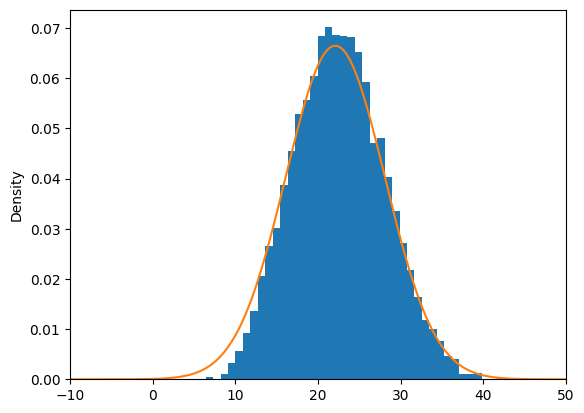

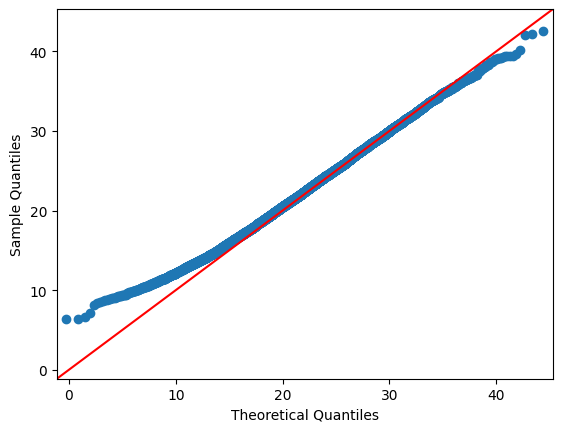

22.547613
5.4937983


In [12]:
np.random.seed(2)

x = np.random.uniform(-0.5,0.5,10000*N_input)
x = torch.tensor(x, dtype=torch.float32).reshape(10000, N_input)
X_predict = torch.tensor([1,2,1]*10000, dtype=torch.float32).reshape(10000,3)
X_predict = torch.column_stack([X_predict,x]) #model inputs for x_1=1, x_2=2 and x_3=1

with torch.no_grad():
    y_sample = model_RQ(X_predict) #model outputs

y_sample = y_sample.reshape(1,-1).numpy()[0] 
print(y_sample[1:10]) #first 10 generated samples

#histogram
plt.hist(y_sample, bins = 40, density=True) 
x_axis = np.arange(-50, 50, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, np.exp(3)+2*1**2, 1+1+2**2)) 
plt.ylabel("Density")
plt.xlim(-10, 50)
plt.show()

#qq plot
sm.qqplot(y_sample, norm, loc=np.exp(3)+2*1**2, scale=1+1+2**2, line = '45') 
plt.show()

print(np.mean(y_sample)) #sample mean
print(np.std(y_sample)) #sample sd